In [10]:
import pandas as pd 
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import Lasso
import tools 

In [11]:
# read the data
# df = pd.read_pickle('data/selected_data.pkl')
df = pd.read_pickle('data/selected_data.pkl')

# print the shape of the data 
print(f'Data contains {df.shape[0]} rows and {df.shape[1]} columns')

Data contains 83 rows and 62 columns


In [12]:
y_labels = ['gdp_growth']
X_labels = [col for col in df.columns if col not in y_labels+['constant']]


# define the data
X = df[X_labels].values
y = df[y_labels].values

# standardize the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

# Define the number of samples and features
n = X.shape[0] # number of samples
p = df.shape[1] # number of features

In [20]:
class MyLasso_123:
    def __init__(self, X, y, xlabels:list=None, max_iter:int=10_000, tol:float=1e-4, fit_intercept:bool=False):
        self.X = X
        self.xlabels = xlabels
        self.y = y
        self.max_iter = max_iter
        self.tol = tol
        self.fit_intercept = fit_intercept
    
    def lasso(self, lambda_):
        """ """
        # Lasso regression
        lasso = Lasso(alpha=lambda_, max_iter=self.max_iter,fit_intercept=self.fit_intercept, tol=self.tol)
        fit = lasso.fit(self.X, self.y)
        fit.feature_names_in_ = self.xlabels
        return fit

In [14]:
x_chosen = X[:,:]
y_chosen = y[:]
# step 2: calculate beta_pilot = beta ( pilot_lambda)
class penalty_term:
    def __init__(self, X:np.ndarray, y:np.ndarray, alpha:float, c:float, n:int, p:int):
        self.n = n
        self.p = p
        self.X = X
        self.y = y
        self.alpha = alpha
        self.c = c
    
    def _max_term(self, func:callable, **kwargs):
        # calculate the max term
        max_term = {}
        for j in range(self.X.shape[1]):
            max_term[j] = func(self.X[:,j], **kwargs)
        return max(max_term.values())
    
    def _scale_factor(self, ):
        return 2*self.c/np.sqrt(self.n)
    
    def _quantile_factor(self, ):
        return norm.ppf(1-self.alpha/(2*p))

    def brt_rule(self, sigma:float):
        scale = self._scale_factor() * sigma
        quantile = self._quantile_factor()
        max_term = self._max_term(lambda x: np.sqrt(np.mean(x**2)))
        return scale*quantile*max_term
    def bcch_pilot_rule(self):
        scale = self._scale_factor()
        quantile = self._quantile_factor()
        max_term = self._max_term(func=(lambda x, y: np.sqrt(np.mean((y-y.mean())**2*x**2))), y=self.y)
        return scale*quantile*max_term
    def bcch_rule(self, residuals:np.ndarray):
        scale = self._scale_factor() # scale factor
        quantile = self._quantile_factor()
        max_term = self._max_term(func=(lambda x, y: np.sqrt(np.mean((y-y.mean())**2*x**2))), y=residuals)
        return scale*quantile*max_term

lasso_ = MyLasso_123(X=x_chosen, y=y_chosen)

print('BCCH \n','---'*10,)
print('Baby step')
penalty_term_obj = penalty_term(X=x_chosen, y=y_chosen, alpha=0.05, c=1.1, n=n, p=p)
p_lambda = penalty_term_obj.bcch_pilot_rule()
beta_pilot = lasso_.lasso(p_lambda)
print(f'We get a lambda={p_lambda:.4f}\n',beta_pilot,'\n', '---'*2)

# d
print('Grown up step')
residuals = y_chosen - x_chosen @ beta_pilot
bcch_lambda = penalty_term_obj.bcch_rule(residuals=residuals)


beta_bcch = lasso_.lasso(bcch_lambda)
print(f'We get a lambda={bcch_lambda:.4f}\n',beta_bcch)
# print(f'lambda: {bcch_lambda:.6f} \n bcch betas\n', beta_bcch)
print('---'*10,'\n'*2)
# try with BRT 

print('BRT \n','---'*10,)
brt_lambda = penalty_term_obj.brt_rule(sigma=0.1)
beta_brt = lasso_.lasso(brt_lambda)
print(f'We get a lambda={brt_lambda:.4f}\n',np.around(beta_brt,2))
print('---'*10,)



BCCH 
 ------------------------------
Baby step
We get a lambda=0.8091
 [-0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0.] 
 ------
Grown up step
We get a lambda=0.8091
 [-0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0.]
------------------------------ 


BRT 
 ------------------------------
We get a lambda=0.0809
 [-0.36 -0.   -0.   -0.   -0.    0.    0.06 -0.    0.    0.09 -0.   -0.
 -0.   -0.   -0.    0.01  0.23  0.   -0.    0.01 -0.    0.   -0.    0.
 -0.   -0.02  0.    0.   -0.    0.    0.11 -0.04 -0.04  0.    0.    0.08
  0.    0.    0.    0.   -0.   -0.   -0.   -0.    0.   -0.31 -0.    0.
 -0.27  0.

In [49]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.00001,1,100)

coefs=[]
non_zeros = {}
lss = MyLasso_123(X=x_chosen, y=y_chosen, max_iter=100_000, fit_intercept=False)

for lamb in penalty_grid:
    fit = lss.lasso(lamb)
    non_zeros[lamb] = len([i for i in range(len(fit.coef_)) if fit.coef_[i] != 0])
    coefs.append({name: coef for name, coef in zip(X_labels, fit.coef_)}) # Note how we extract the coefficients from fit and append them to coefs

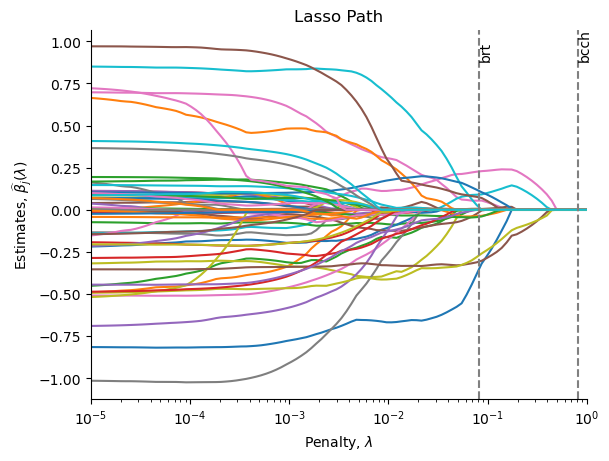

In [46]:
# Plot lasso path
tools.plot_lasso_path(penalty_grid, [list(val.values()) for val in coefs],legends=X_labels, vlines={'brt':brt_lambda,'bcch':bcch_lambda},)